# Nested sampling algorithm

From *dynesty* crash course, https://dynesty.readthedocs.io/en/stable/dynamic.html

Nested sampling is a method for estimating the Bayesian evidence $\mathcal{Z}$ first proposed and developed by John Skilling. The basic idea is to approximate the evidence by integrating the prior in nested “shells” of constant likelihood. Unlike Markov Chain Monte Carlo (MCMC) methods which can only generate samples proportional to the posterior, Nested Sampling simultaneously estimates both the evidence and the posterior. It also has a variety of appealing statistical properties, which include:

1. well-defined stopping criteria for terminating sampling,

2. generating a sequence of independent samples,

3. flexibility to sample from complex, multi-modal distributions,

4. the ability to derive how statistical and sampling uncertainties impact results from a single run, and

5. being trivially parallelizable.

Recap the *bayesian evidence*:

$$P(\boldsymbol{D}|M) = \mathcal{Z} = \int_{\Omega_\Theta}\mathcal{L}(\boldsymbol{\Theta})\pi(\boldsymbol{\Theta})d\boldsymbol{\Theta}$$

The integral is taken over the entire domain $\Omega_\Theta$ of $\boldsymbol{\Theta}$ (prior volume). For complicated data and models, the posterior is often intractable and must be estimated using numerical methods.

Nested sampling is a method for estimating the Bayesian evidence 
 first proposed and developed by John Skilling. The basic idea is to approximate the evidence by integrating the prior in nested “shells” of constant likelihood. Unlike Markov Chain Monte Carlo (MCMC) methods which can only generate samples proportional to the posterior, Nested Sampling simultaneously estimates both the evidence and the posterior. It also has a variety of appealing statistical properties, which include:

- well-defined stopping criteria for terminating sampling,
- generating a sequence of independent samples,
- flexibility to sample from complex, multi-modal distributions,
- the ability to derive how statistical and sampling uncertainties impact results from a single run, and
- being trivially parallelizable.

Nested Sampling attempts to estimate $\mathcal{L}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the prior volume. 

$$X(\lambda) = \int_{\Theta:\mathcal{L}>\lambda}\pi(\boldsymbol{\Theta})d\boldsymbol{\Theta}$$

$X(\lambda)$ is the total prior mass where the likelihood is greater than $\lambda$ (iso-likelihood contour).

We can write, thanks to Fubini theorem:

$$\mathcal{Z}=\int \mathcal{L}(\theta)\pi(\theta)d\theta = \int \left( \int_0^{\mathcal{L}(\theta)} d\lambda  \right)\pi(\theta)d\theta= \int_0^{+\infty} \left( \int_{\mathcal{L}(\theta)>\lambda} \pi(\theta)d\theta  \right) d\lambda$$

Since $X(\lambda)$ is decreasing and invertible, let $\lambda=\mathcal{L}(X)$. Then:

$$\int_0^{+\infty} X(\lambda)d\lambda = \int_1^0 X \frac{d\mathcal{L}(X)}{dX}dX = [\mathcal{L}(X)\, X ]_1^0 - \int_1^0 \mathcal{L}(X)\,dX = \int_0^1 \mathcal{L}(X)dX$$

(The limits flip because $X(\lambda)$ goes from 1 to 0 as $\lambda$ increases from 0 to $+\infty$). 

$$\mathcal{Z}=\int_0^1 \mathcal{L}(X)\,dX$$

This is the nested sampling identity, expressing the Bayesian evidence as an integral over prior volume.



**Algorithm**

Draw $K$ live points from the prior $\pi(\Theta)$. At each iteration $i$ remove the live point with the lowest likelihood $\mathcal{L}_i$ and replace it with a new live point sampled from the prior subject to the constrain $\mathcal{L}_{i+1} \geq \mathcal{L}$. This sampling procedure actually allows us to estimate the prior volume of the previous live point (a “dead” point) as:
$$
\ln{X_i}\approx\frac{i\pm\sqrt{i}}{K}
$$
Why this? Let $t_i$ be the shrinkage factor, such that $X_i = t_i X_{i-1}$. The distribution of $t_i$, assuming uniform live points, is:
$$
P(t)= Kt^{K-1} \text{      the PDF of the largest of K uniform samples}
$$
This is a **Beta distribution**: $t_i\sim \text{Beta}(K,1)$


Once some stopping criteria are reached and sampling terminates, the remaining set of live points are distributed uniformly within the final prior volume. These can then be “recycled” and added to the list of samples.

The evidence integral can be numerically estimated:

$$
\mathcal{Z} = \int_0^1\mathcal{L}(X)dX\approx\sum_{p=1}^Nf(\mathcal{L_i})f(\Delta X_i) = \sum_{i=1}^Nw_i
$$

where $\mathcal{L_i}$ is the likelihood of the $i$-th dead point, $X_i$ is the prior volume encolsed by likelihood contour at iteration$i$ (shrinking exopentially), and $\Delta X_i = X_{i-1}-X_i$ is the change in prior volume between two iterations. $w_i$ is each point estimated weight (contribution of the point to the evidence).

For linear integration scheme using rectangles $f(\mathcal{L}_i)=\mathcal{L}_i$ and $f(\Delta X_i)=X_{i-1}-X_i$

What's the intuition?

Think of the evidence integral like this:

- You're integrating likelihood over prior mass.
- At each iteration, you remove the worst (lowest likelihood) point, which lies on the boundary of the remaining prior volume.
- You know the approximate size of the prior volume at that step: $X_i$​.
- The change $\Delta X_i$​ tells you "how much prior mass was removed."
- Multiply that with the likelihood at the boundary, $\mathcal{L}_i$​, and you get a contribution to the evidence.

So you’re numerically summing small rectangles with width = $\Delta X_i$ and height = $\mathcal{L}_i$.

That's just a left Riemann sum of $\int_0^1 \mathcal{L}(X)dX$.

**Posterior Estimation**

We can subsequently estimate posteriors “for free” from the same $N$ dead points by assigning each sample its associated importance weight: 
$$
P(\Theta) = P(X_i)=p_i = \frac{\hat{w_i}}{\sum_{i=1}^N\hat{w}_i}=\frac{\hat{w}_i}{\hat{\mathcal{Z}}}
$$

Each **dead point** $\theta_i$ has:

- A likelihood $\mathcal{L}_i = p(\text{data} \mid \theta_i)$  
- A prior volume element $\Delta X_i$

From this, we define the **importance weight**:

$$
w_i = \mathcal{L}_i \, \Delta X_i
$$

The evidence (marginal likelihood) is approximated by:

$$
Z = \int \mathcal{L}(X) \, dX \approx \sum_i w_i
$$

Then, the **posterior probability** for each sample is simply:

$$
p(\theta_i \mid \text{data}) \approx \frac{w_i}{Z}
$$

To do typical posterior analysis — histograms, quantiles, etc. — we want samples that are **equally probable**, i.e. drawn from the posterior. Resampling creates a new set of samples:

- Still from your original samples
- But with replacement, in proportion to their weights

So that the resulting samples are uniform in probability, i.e., they mimic a draw from the true posterior.

**Stopping Criteria**
The remaining evidence at iteration $\Delta\hat{\mathcal{Z}}_i$ at iteration $i$ can roughly be bounded by: 
$$
\Delta\hat{\mathcal{Z}}_i\approx \mathcal{L}_{\rm max}X_i
$$
where $\mathcal{L}_{\rm max}$ is the the maximum likelihood point contained within the remaining set of $K$ live points. This essentially assumes that the remaining prior volume interior to the last dead point is a uniform slab with likelihood $\mathcal{L}_{\rm max}$. This can be turned into a relative stopping criterion by using the (log-)ratio between the current estimated evidence $\hat{\mathcal{Z}}_i$ and the remaining evidence $\Delta \hat{\mathcal{Z}}_i$:
$$
\Delta \ln \hat{\mathcal{Z}}_i = \ln\left( \hat{\mathcal{Z}}_i + \Delta \hat{\mathcal{Z}}_i \right) - \ln \hat{\mathcal{Z}}_i
$$
Stopping at a given $\Delta \ln \hat{\mathcal{Z}}_i$ value then means sampling until only a fraction of the evidence remains unaccounted for.

**Challenges**

Nested Sampling has two main main theoretical requirements:

- Samples must be evaluated sequentially subject to the likelihood constraint 
- All samples used to compute/replace live points must be independent and identically distributed (i.i.d.) random variables drawn from the prior.

In [7]:
# Animation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from IPython.display import display, HTML

from scipy.stats import norm
from scipy.stats import multivariate_normal


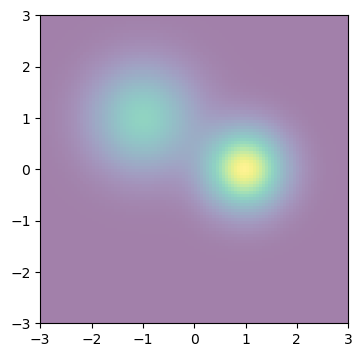

In [8]:
# --- Target distribution: mixture of two Gaussians ---
def target_pdf(x):
    gauss1 = multivariate_normal(mean=[1, 0], cov=[[0.3, 0], [0, 0.3]])
    gauss2 = multivariate_normal(mean=[-1, 1], cov=[[0.5, 0], [0, 0.5]])
    return gauss1.pdf(x) + gauss2.pdf(x)

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')

# Plot target PDF background
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.array([target_pdf(p) for p in pos.reshape(-1, 2)]).reshape(100, 100)
ax.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='viridis', alpha=0.5)
plt.show()

In [10]:
# --- Uniform prior on a bounding box ---
def sample_prior(n_samples):
    # Assuming prior is uniform in [-4, 4] x [-4, 4]
    return np.random.uniform(low=[-4, -4], high=[4, 4], size=(n_samples, 2))

# --- Initial setup ---
K = 100
live_points = sample_prior(K)
live_likelihoods = np.array([target_pdf(x) for x in live_points])

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Initial scatter plot
sc = ax.scatter(live_points[:, 0], live_points[:, 1],
                c=live_likelihoods, cmap='viridis',
                s=30, edgecolor='k')

# Red point to show worst likelihood
red_point = ax.scatter([], [], c='red', s=60, edgecolor='k', label='Worst point')
plt.colorbar(sc, ax=ax, label='Likelihood')

# Create cross-plot for rejected points
rejected_points = []
cross_scat = ax.scatter([], [], marker='x', c='grey', alpha=0.5,label='Rejected', s=20)

i = 0
X = [1]
Z = [0] 
w = [0]

# --- Animation update function ---
def update(frame):
    global live_points, live_likelihoods, i, X, Z

    # Find and show the worst point (lowest likelihood)
    min_index = np.argmin(live_likelihoods)
    worst_point = live_points[min_index]
    red_point.set_offsets([worst_point])

    # Remove it from live points
    worst_likelihood = live_likelihoods[min_index]
    live_points = np.delete(live_points, min_index, axis=0)
    live_likelihoods = np.delete(live_likelihoods, min_index)
    
    
    # Resample a new point with higher likelihood
    while True:
        new_point = sample_prior(1)[0]
        new_likelihood = target_pdf(new_point)
        if new_likelihood > worst_likelihood:
            break
        else:
            rejected_points.append(new_point)

    # Add new point
    live_points = np.vstack([live_points, new_point])
    live_likelihoods = np.append(live_likelihoods, new_likelihood)

    # Update scatter plot
    sc.set_offsets(live_points)
    sc.set_array(live_likelihoods)
    # Update rejected points plot
    if rejected_points:
        cross_scat.set_offsets(np.array(rejected_points))

    i += 1
    log_X_new = -i / K
    log_err_X = -np.sqrt(i)/K
    X_new = np.exp(log_X_new)
    delta_X = X[-1] - X_new

    Z.append(Z[-1] + worst_likelihood * delta_X)
    
    X.append(X_new)

    w.append(worst_likelihood*delta_X)
    
    ax.set_title(
        rf"$\ln X \approx {log_X_new:.3f} \pm {log_err_X:.5f}$" "\n"
        rf"$w_i = {w[-1]:.2e} \quad \mathrm{{Evidence}} = {Z[-1]:.2e}$",
        fontsize=12
    )

    return sc,

# --- Create animation ---
ani = FuncAnimation(
    fig, update,
    frames=200, interval=200, blit=False
)

ani.save("nested_sampling.gif", writer="pillow", fps=5)
#display(HTML(ani.to_jshtml()))
plt.close()


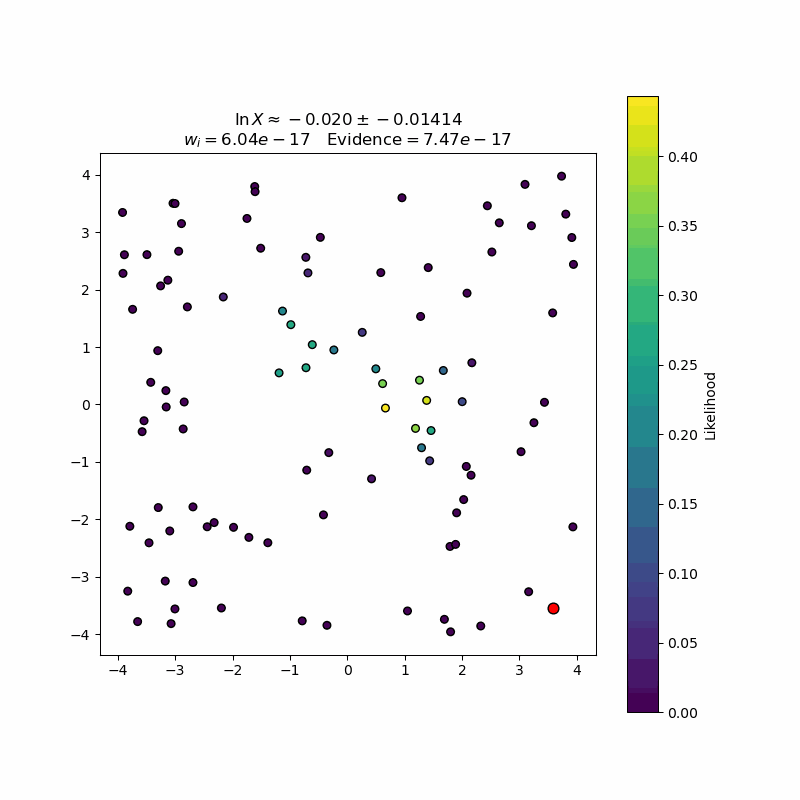

In [4]:
from IPython.display import Image, Video
# For GIF:
Image("nested_sampling.gif")

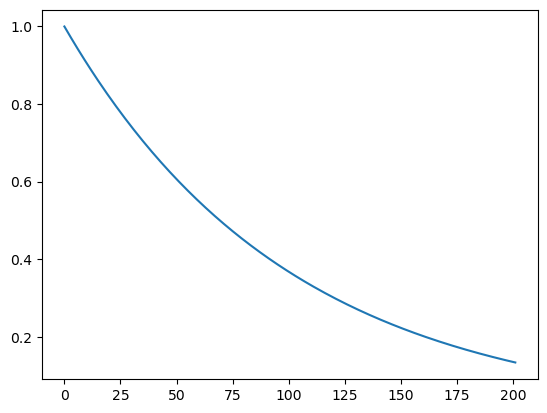

In [18]:
plt.plot(range(len(X)),X);

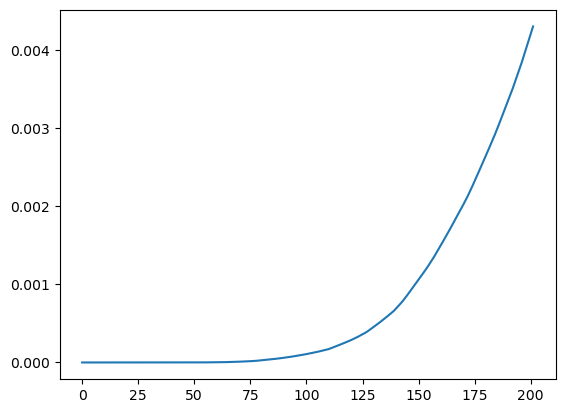

In [19]:
plt.plot(range(len(Z)),Z);

# Let's run nested sampling algorithm a little longer

In [39]:
K = 100
live_points = sample_prior(K)
live_likelihoods = np.array([target_pdf(x) for x in live_points])

i = 0
X = [1]
Z = [0] ### ?
w = [0]

samples = []  # <--- List to store dead points

for j in range(10000):
    global live_points, live_likelihoods, i, X, Z

    # Find and show the worst point (lowest likelihood)
    min_index = np.argmin(live_likelihoods)
    worst_point = live_points[min_index]

    samples.append(worst_point)  # <--- Store dead point
    
    red_point.set_offsets([worst_point])

    # Remove it from live points
    worst_likelihood = live_likelihoods[min_index]
    live_points = np.delete(live_points, min_index, axis=0)
    live_likelihoods = np.delete(live_likelihoods, min_index)
    
    # Resample a new point with higher likelihood
    internal_counter = 0
    while True:
        new_point = sample_prior(1)[0]
        new_likelihood = target_pdf(new_point)
        internal_counter += 1
        if new_likelihood > worst_likelihood:
            break
        if internal_counter > 2000:
            break
    if internal_counter > 2000:
        break
    

    # Add new point
    live_points = np.vstack([live_points, new_point])
    live_likelihoods = np.append(live_likelihoods, new_likelihood)

    i += 1
    log_X_new = -i / K
    log_err_X = -np.sqrt(i)/K
    X_new = np.exp(log_X_new)
    delta_X = X[-1] - X_new

    w.append(worst_likelihood*delta_X)

    Z.append(Z[-1] + worst_likelihood * delta_X)
    
    X.append(X_new)

In [40]:
print(len(X))

644


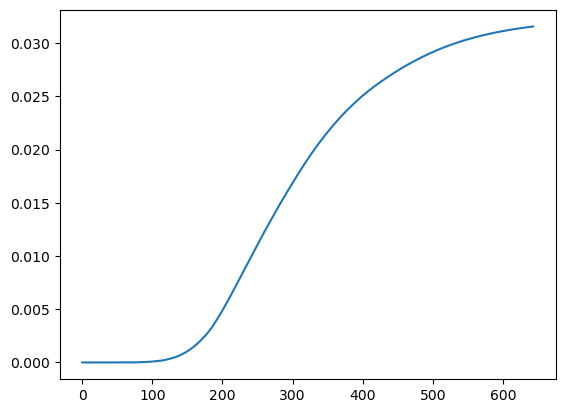

In [41]:
plt.plot(range(len(Z)),Z)

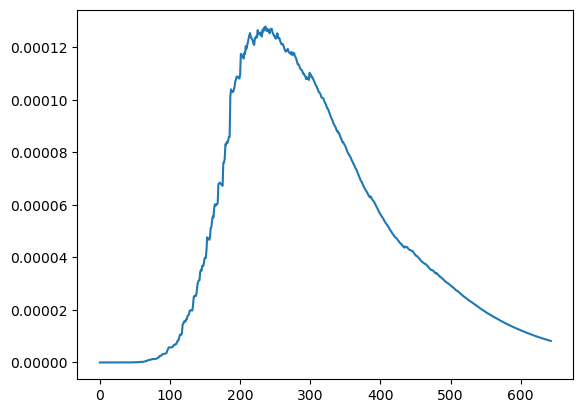

In [42]:
plt.plot(range(len(w)),w)

In [47]:
print(len(samples))

644


In [45]:
print(len(w))

644


In [48]:
samples = np.array(samples)

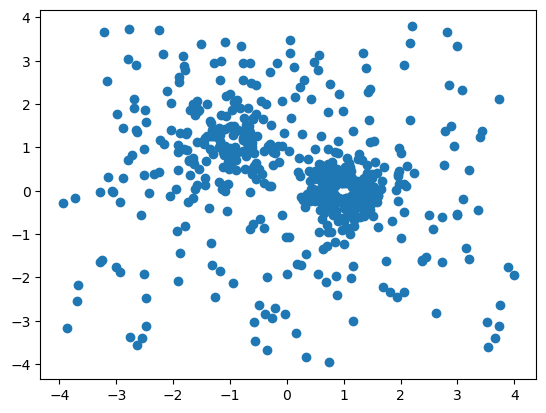

In [49]:
plt.scatter(samples[:,0],samples[:,1])

### Resampling to get a new set of unweighted samples from the posterior. 

In [50]:
from numpy.random import choice

# Normalize weights
normalized_weights = w / np.sum(w)

# Resample points according to weights
posterior_samples = np.array([
    samples[i] for i in choice(len(samples), size=K, p=normalized_weights)
])


(-4.0, 4.0)

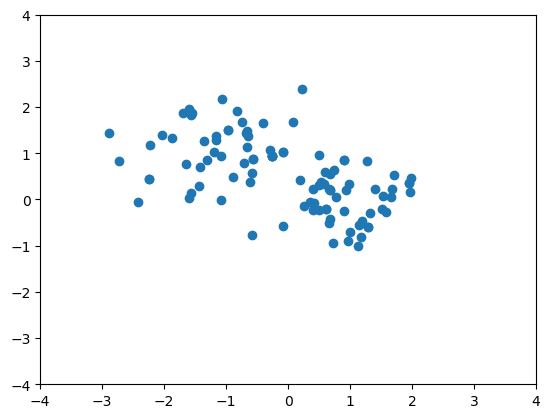

In [53]:
plt.scatter(posterior_samples[:,0],posterior_samples[:,1])
plt.xlim(-4,4)
plt.ylim(-4,4)